In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score, learning_curve, validation_curve
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from MajorityVoteClassifier import MajorityVoteClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
%matplotlib inline

In [2]:
path = "https://raw.githubusercontent.com/DSEI21000-S21/project-tennis-ml/main/wta_matches/wta_matches-2000-2021_expanded.csv"

def readData(path):
    df = pd.read_csv(path)
    return df

def dropGibberishRows(dataframe, column_name, filter_variable):
    index_list = list(dataframe[dataframe[column_name] == filter_variable].index)
    dataframe = dataframe.drop(index_list)
    return dataframe

#def encodeColumn(dataframe, column_list = []):
    #df = pd.get_dummies(dataframe, columns= column_list)
    #return df

def convertDate(dataframe, date):
    dataframe[date] = pd.to_datetime(dataframe[date], format = '%Y%m%d', errors='coerce')
    return dataframe

def addDateFeatures(dataframe, date):
    dataframe['year'] = dataframe[date].dt.year
    dataframe['month'] = dataframe[date].dt.month
    dataframe['day'] = dataframe[date].dt.day
    return dataframe

def appendTarget(dataframe, winner, loser):
    dataframe[winner] = 1
    dataframe[loser] = 0
    return dataframe

def getMissingDataPercentage(dataframe):
    percent_missing = dataframe.isnull().sum() * 100 / len(dataframe)
    missing_value_df = pd.DataFrame({'column_name': dataframe.columns,
                                 'percent_missing': percent_missing})
    pd.set_option("max_rows", None)
    return missing_value_df

def formatColumns(dataframe):
    columns = list(dataframe.columns)
    renamed_columns = [i.lower().strip().replace(' ', "_").replace(':','') for i in columns]
    renamed_columns_dict = {columns[i]: renamed_columns[i] for i in range(len(columns))}
    dataframe = dataframe.rename(columns = renamed_columns_dict)
    return dataframe

def convertColumnsToNumeric(dataframe, columns = []):
    dataframe[columns] = dataframe[columns].apply(pd.to_numeric, errors ='coerce')
    return dataframe 

def fillMissingDataMode(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(dataframe[cols].mode().iloc[0])
    return dataframe

def dropColumn(dataframe, column_list = []):
    return dataframe.drop(column_list, axis =1)

def fillMissingDataMean(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(dataframe[cols].mean().iloc[0])
    return dataframe

def fillMissingData999(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(999)
    return dataframe

In [3]:
wta_data = readData(path)
wta_data = dropColumn(wta_data, ['player_entry'])
wta_data = fillMissingDataMode(wta_data, ['surface', 'player_hand'])
wta_data = fillMissingDataMean(wta_data, ['player_height', 'player_age', 'minutes', 'ace', 'double_fault', 'service_points_won', 'first_serve_made', 'first_serve_won', 
'second_serve_won', 'serve_game', 'break_point_saved', 'break_point_faced', 'player_rank','player_rank_points'])
wta_data = fillMissingData999(wta_data, ['player_seed'])
wta_data = convertDate(wta_data, 'tourney_date')
wta_data = addDateFeatures(wta_data, 'tourney_date')
wta_data = dropColumn(wta_data, ['player_ioc', 'score', 'tourney_id', 'tourney_date', 'player_name'])
#wta_data = encodeColumn(wta_data, ['tourney_name','surface', 'tourney_level', 'player_hand','round'])
wta_data = formatColumns(wta_data)

In [4]:
getMissingDataPercentage(wta_data)

,column_name,percent_missing
tourney_name,tourney_name,0.0
surface,surface,0.0
draw_size,draw_size,0.0
tourney_level,tourney_level,0.0
match_num,match_num,0.0
player_id,player_id,0.0
player_seed,player_seed,0.0
player_hand,player_hand,0.0
player_height,player_height,0.0
player_age,player_age,0.0


In [5]:
wta_data.info(verbose =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119438 entries, 0 to 119437
Data columns (total 28 columns):
tourney_name          119438 non-null object
surface               119438 non-null object
draw_size             119438 non-null int64
tourney_level         119438 non-null object
match_num             119438 non-null int64
player_id             119438 non-null int64
player_seed           119438 non-null float64
player_hand           119438 non-null object
player_height         119438 non-null float64
player_age            119438 non-null float64
best_of               119438 non-null int64
round                 119438 non-null object
minutes               119438 non-null float64
ace                   119438 non-null float64
double_fault          119438 non-null float64
service_points_won    119438 non-null float64
first_serve_made      119438 non-null float64
first_serve_won       119438 non-null float64
second_serve_won      119438 non-null float64
serve_game            119438

In [6]:
wta_data.describe()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,second_serve_won,serve_game,break_point_saved,break_point_faced,player_rank,player_rank_points,target,year,month,day
count,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,...,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000
mean,54.576600,82.883705,202298.029580,678.641488,173.385424,24.219136,3.002579,155.925050,72.479200,73.225291,...,78.019033,131.635498,73.627145,75.859651,95.349947,1242.600897,0.500000,2009.847620,5.331821,16.041829
std,41.109025,171.380133,3351.576382,463.529275,5.000963,4.647098,0.071770,37.753336,84.053933,83.532933,...,79.508748,71.195287,83.105517,81.282219,127.100176,1439.037247,0.500002,6.066933,2.911543,8.638772
min,2.000000,1.000000,200001.000000,1.000000,153.000000,14.039699,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000
25%,30.000000,9.000000,201212.000000,11.000000,173.000000,21.122519,3.000000,173.385424,1.000000,3.000000,...,10.000000,17.000000,3.000000,7.000000,26.000000,391.000000,0.000000,2005.000000,3.000000,8.000000
50%,32.000000,25.000000,201450.000000,999.000000,173.385424,23.956194,3.000000,173.385424,5.000000,6.000000,...,17.000000,173.385424,8.000000,13.000000,60.000000,777.000000,0.500000,2010.000000,5.000000,16.000000
75%,64.000000,92.000000,201619.000000,999.000000,174.000000,26.964408,3.000000,173.385424,173.385424,173.385424,...,173.385424,173.385424,173.385424,173.385424,113.000000,1470.000000,1.000000,2015.000000,8.000000,23.000000
max,128.000000,2701.000000,223140.000000,999.000000,189.000000,173.385424,5.000000,2475.000000,173.385424,173.385424,...,173.385424,173.385424,173.385424,173.385424,1482.000000,13615.000000,1.000000,2021.000000,12.000000,31.000000


In [7]:
wta_data.head()

,tourney_name,surface,draw_size,tourney_level,match_num,player_id,player_seed,player_hand,player_height,player_age,...,second_serve_won,serve_game,break_point_saved,break_point_faced,player_rank,player_rank_points,target,year,month,day
0,Fed Cup G1 PO: JPN vs CHN,Hard,4,D,1,201419,999.0,R,172.000000,18.173854,...,173.385424,173.385424,173.385424,173.385424,190.0,121.0,1,2000,4,30
1,Fed Cup G1 PO: JPN vs CHN,Hard,4,D,2,200085,999.0,R,163.000000,24.821355,...,173.385424,173.385424,173.385424,173.385424,22.0,1230.0,1,2000,4,30
2,Fed Cup WG SF: USA vs BEL,Carpet,4,D,1,200652,999.0,L,173.385424,26.973306,...,173.385424,173.385424,173.385424,173.385424,4.0,3255.0,1,2000,11,22
3,Fed Cup WG SF: USA vs BEL,Carpet,4,D,2,200128,999.0,R,189.000000,24.457221,...,173.385424,173.385424,173.385424,173.385424,2.0,5022.0,1,2000,11,22
4,Fed Cup WG SF: CZE vs ESP,Carpet,4,D,1,200017,999.0,R,173.385424,28.928131,...,173.385424,173.385424,173.385424,173.385424,9.0,2132.0,1,2000,11,21


**check for missing values**

In [8]:
#Total missing values
wta_data.isnull().sum().sum()

0

In [9]:
# Random Seed
SEED = 42
np.random.seed = SEED

**check if the data is balance**     
target is our target variable, we want to make sure the data is balanced

In [10]:
#check if the data is balance
wta_data['target'].value_counts()

1    59719
0    59719
Name: target, dtype: int64

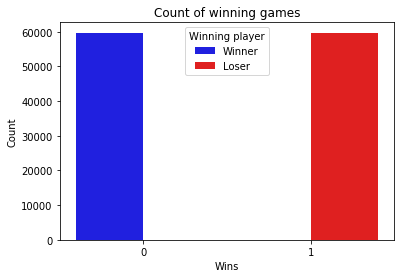

In [11]:
ax = sns.countplot(wta_data['target'], hue=wta_data['target'], palette=['blue', 'red'])
ax.set(xlabel='Wins', ylabel='Count')
ax.legend(title='Winning player', loc='upper center', labels=['Winner', 'Loser'])
ax.set_title('Count of winning games')
plt.show()

**Checking correlation between features**

In [12]:
wta_data_corr = wta_data.corr()
wta_data_corr['target'].sort_values(ascending=False)

target                1.000000e+00
player_rank_points    1.841243e-01
player_height         3.715075e-02
first_serve_won       1.893883e-02
player_age            1.001561e-02
second_serve_won      7.220266e-03
ace                   3.701899e-03
first_serve_made      3.578390e-04
serve_game            2.823581e-04
month                 1.006312e-18
best_of              -1.036141e-19
draw_size            -2.575920e-19
day                  -8.126050e-19
match_num            -4.078054e-18
minutes              -7.204443e-18
year                 -1.129621e-17
double_fault         -2.578640e-03
break_point_saved    -3.247645e-03
service_points_won   -7.119074e-03
break_point_faced    -1.264895e-02
player_id            -4.991135e-02
player_rank          -1.104391e-01
player_seed          -2.060586e-01
Name: target, dtype: float64

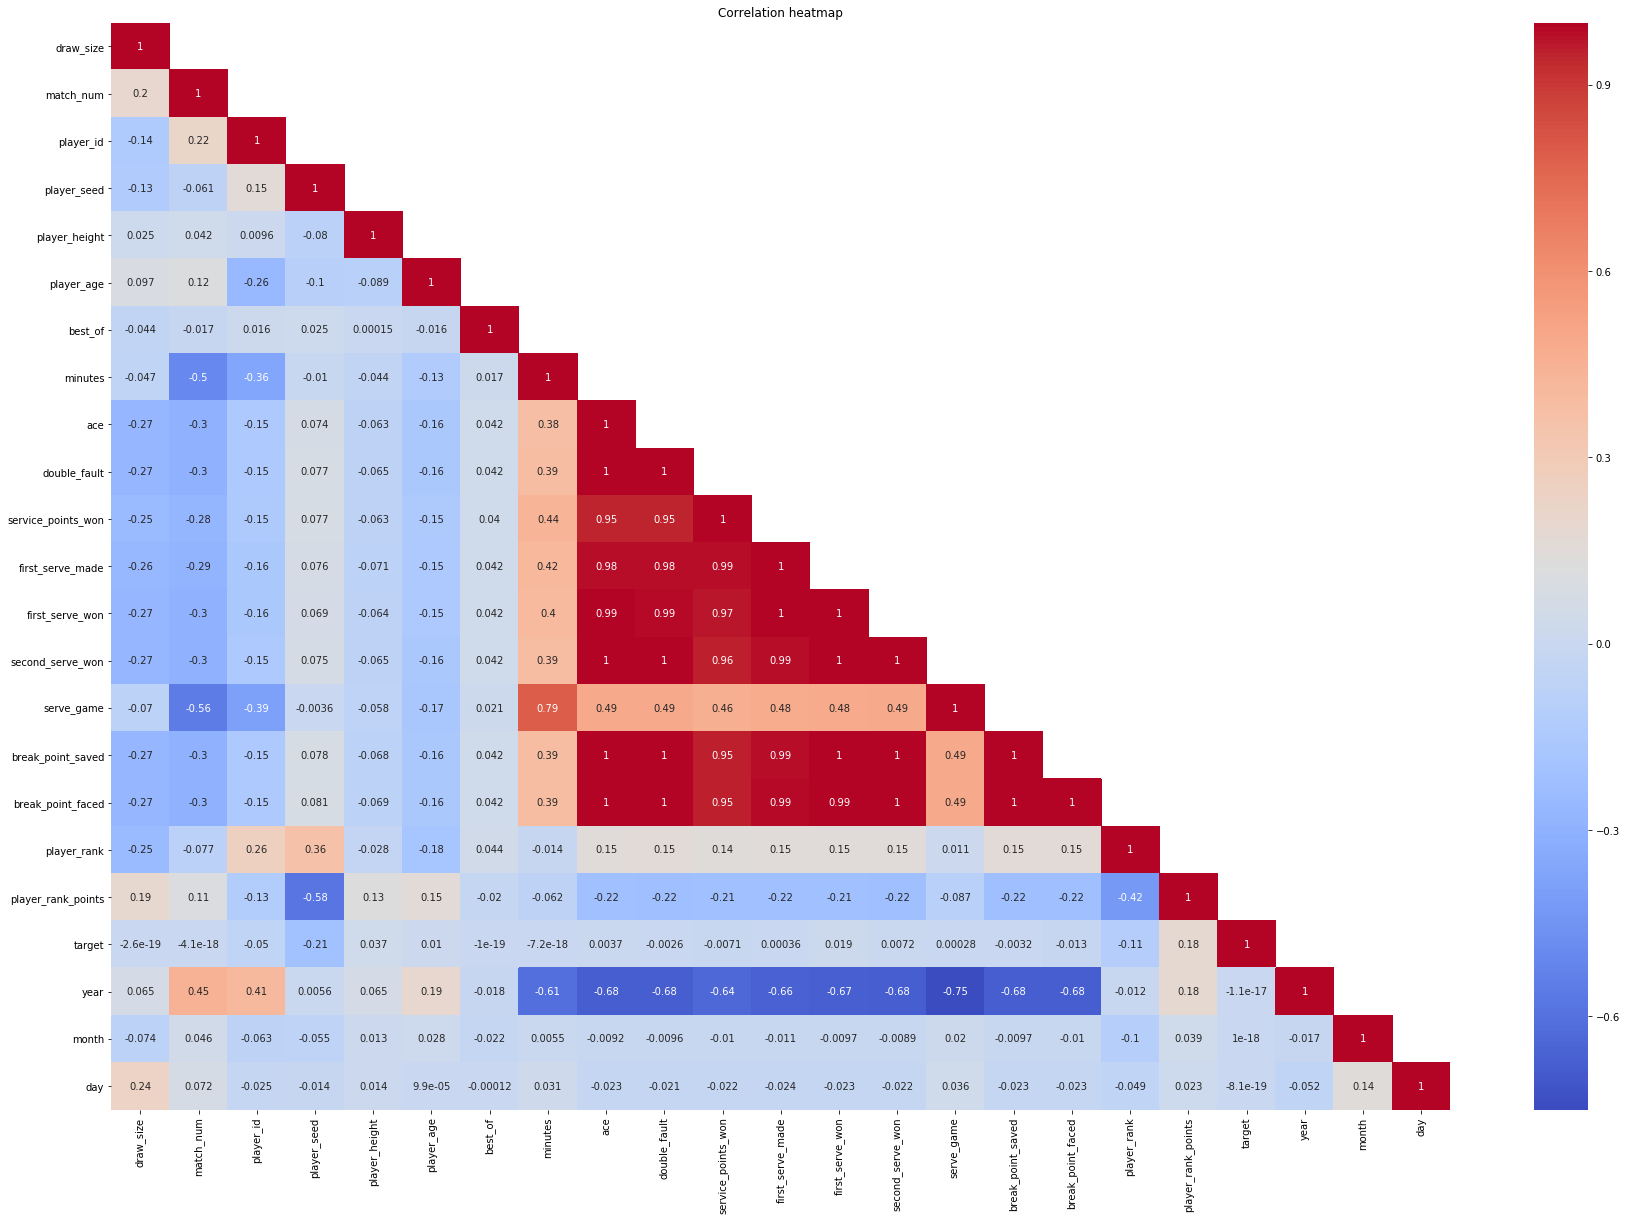

In [13]:
f, ax = plt.subplots(figsize= (30, 20))
lower = wta_data_corr.where(np.tril(np.ones(wta_data_corr.shape)).astype(np.bool))
hmap=sns.heatmap(lower,cmap="coolwarm", annot=True)
ax.set_title('Correlation heatmap')
plt.savefig('clean-corr-half.png')

**player_rank_points** is the highest positively correlated variable to the target variabl whereas **player_seed** is the negatively correlated to the target variable. 

**Convert the categorical columns to numeric**

In [14]:
def encodeColumn(dataframe, column_list = []):
    df = pd.get_dummies(dataframe, columns= column_list)
    return df

In [15]:
wta_data_numerical = encodeColumn(wta_data, ['tourney_name','surface', 'tourney_level', 'player_hand','round'])
wta_data_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119438 entries, 0 to 119437
Columns: 2782 entries, draw_size to round_SF
dtypes: float64(15), int64(8), uint8(2759)
memory usage: 335.2 MB


In [16]:
reduced_df = wta_data_numerical[(wta_data_numerical['year']== 2019 & 2020)]
reduced_df.head()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,player_hand_U,round_BR,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
45837,32,270,201496,2.0,177.0,26.269678,3,70.0,1.0,2.0,...,0,0,0,0,0,0,1,0,0,0
45838,32,271,201513,999.0,178.0,27.069131,3,101.0,6.0,4.0,...,0,0,0,0,0,0,1,0,0,0
45839,32,272,201512,999.0,168.0,29.062286,3,89.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
45840,32,273,201212,999.0,166.0,36.317591,3,78.0,3.0,3.0,...,0,0,0,0,0,0,1,0,0,0
45841,32,274,202428,3.0,182.0,24.854209,3,85.0,3.0,2.0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6156 entries, 45837 to 108633
Columns: 2782 entries, draw_size to round_SF
dtypes: float64(15), int64(8), uint8(2759)
memory usage: 17.3 MB


**Split data into training and testing sets**

In [27]:
X = reduced_df.loc[:, reduced_df.columns != 'target']
y = reduced_df['target']



**Methodology**

We will be doing feature scaling using standardization. We will then compare the models with and without features scaled. Except for decision trees and random forests.

**Standardization**

In [28]:
#standardize both training and testing data
sc = StandardScaler()
X_std = sc.fit_transform(X)


**Models**

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

**Apply the models on the unstandardized Data**

In [48]:
# fill in
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_tr_pred = knn_pipe.predict(X_train)
y_ts_pred = knn_pipe.predict(X_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_train, y_tr_pred), 
                                                                         accuracy_score(y_test, y_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_train, y_tr_pred, average='binary'), 
                                                                           precision_score(y_test, y_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_train, y_tr_pred, average='binary'), 
                                                                     recall_score(y_test, y_ts_pred, average='binary')))

Accuracy score on train: 0.4998839637967046
Accuracy score on test: 0.5002707092582567

f1 score on train: 0.0
f1 score on test: 0.0

Precision score on train: 0.0
Precision score on test: 0.0

Recall score on train: 0.0
Recall score on test: 0.0



C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**Apply the models on the Standardized Data**

In [34]:
# fill in
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

knn_ubal = KNeighborsClassifier(n_neighbors=28, metric='minkowski', p=2, weights='uniform')
knn_pipe = make_pipeline(knn_ubal)
knn_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = knn_pipe.predict(X_std_train)
y_std_ts_pred = knn_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

Accuracy score on train: 0.5732188442794152
Accuracy score on test: 0.47969680563075257

f1 score on train: 0.5229571984435798
f1 score on test: 0.42420611144397846

Precision score on train: 0.5929411764705882
Precision score on test: 0.4745308310991957

Recall score on train: 0.4677494199535963
Recall score on test: 0.38353196099674974



**Logistic Regression**

In [39]:
lr = LogisticRegression()
lr_pipe = make_pipeline(lr)
lr_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = lr_pipe.predict(X_std_train)
y_std_ts_pred = lr_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score on train: 0.8171269436064053
Accuracy score on test: 0.7769355711965349

f1 score on train: 0.8197621225983531
f1 score on test: 0.7815482502651112

Precision score on train: 0.80829950383401
Precision score on test: 0.7653167185877466

Recall score on train: 0.831554524361949
Recall score on test: 0.7984832069339112



**DecisionTreeClassifier**

In [41]:
dt = DecisionTreeClassifier()
dt_pipe = make_pipeline(dt)
dt_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = dt_pipe.predict(X_std_train)
y_std_ts_pred = dt_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

Accuracy score on train: 1.0
Accuracy score on test: 0.7303735787763942

f1 score on train: 1.0
f1 score on test: 0.7316810344827587

Precision score on train: 1.0
Precision score on test: 0.7277599142550911

Recall score on train: 1.0
Recall score on test: 0.7356446370530878



**Random Forest**

In [42]:
rf = RandomForestClassifier()
rf_pipe = make_pipeline(rf)
rf_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = rf_pipe.predict(X_std_train)
y_std_ts_pred = rf_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy score on train: 0.9872360176375029
Accuracy score on test: 0.6729832160259881

f1 score on train: 0.9871164207074256
f1 score on test: 0.6524741081703106

Precision score on train: 0.9966887417218543
Precision score on test: 0.6957055214723926

Recall score on train: 0.9777262180974478
Recall score on test: 0.6143011917659805



In [44]:
svc = SVC()
svc.fit(X_std_train, y_std_train)

y_std_tr_pred = svc.predict(X_std_train)
y_std_ts_pred = svc.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score on train: 0.597818519378046
Accuracy score on test: 0.541959935029778

f1 score on train: 0.533009970358394
f1 score on test: 0.4764851485148515

Precision score on train: 0.6356041131105399
Precision score on test: 0.5555555555555556

Recall score on train: 0.4589327146171694
Recall score on test: 0.4171180931744312



**Testing set**

In [23]:
std_pipe = {}
for key in models.keys():
    std_pipe[key] = Pipeline(models[key])
    std_pipe[key].fit(X_std_test, y_std_test)
    print('[{}] Classification accuracy: {:.3f}'
          .format(key, std_pipe[key].score(X_std_test, y_std_test)))

[DummyClassifier] Classification accuracy: 0.497


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LogisticRegression] Classification accuracy: 0.834
[K-Nearest Neighbors] Classification accuracy: 0.688
[DecisionTree] Classification accuracy: 1.000
[RandomForest] Classification accuracy: 0.989


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[SVM] Classification accuracy: 0.626


Logistic Regression best perfomed on the standardized data

**Apply the odels on the unstandardized training Data**

**Training set**

In [54]:
#Split the unstandardized Training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

std_pipe = {}
for key in models.keys():
    std_pipe[key] = Pipeline(models[key])
    std_pipe[key].fit(X_train, y_train)
    print('[{}] Classification accuracy: {:.3f}'
          .format(key, std_pipe[key].score(X_test, y_test)))

[DummyClassifier] Classification accuracy: 0.503


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LogisticRegression] Classification accuracy: 1.000
[K-Nearest Neighbors] Classification accuracy: 0.552
[DecisionTree] Classification accuracy: 1.000
[RandomForest] Classification accuracy: 0.951


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[SVM] Classification accuracy: 0.547


Logistic Regression best perfomed on the unstandardized data.

The accuracy of Decision Trees and Random Forests after scaling the features decreased. Logistic regression and SVM performed well. After standardizing the features, Logistic regression, Random Forest and KNN improve their performances.

Models Evaluation

Feature Importance with random Forests

# GridSearchCV

In [55]:
lr = LogisticRegression(random_state= 42, C = 1)

param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

lr_cv = GridSearchCV(lr, param_grid, cv=10)
lr_cv.fit(X_train, y_train)

print(lr_cv.best_params_) 
print(lr_cv.best_score_)

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

{'C': 0.1}
1.0


**KNN**

In [57]:
param_grid = {'n_neighbors': np.arange(1,20)} 

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=10) 

knn_cv.fit(X_train,y_train) 
print(knn_cv.best_params_) 
print(knn_cv.best_score_)

{'n_neighbors': 16}
0.5580238726790451


**SVM**

In [ ]:
svc = SVC(kernel="linear", random_state=SEED)


param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

gs = GridSearchCV(svc, params_svc, cv=10)

gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

**ROC & AUC**

In [ ]:
clf1 = LogisticRegression(random_state=42, C = 0.001)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=21)
clf4 = RandomForestClassifier(random_state=42)
clf5 = SVC(random_state=42, probability = True, C=0.01, kernel='rbf')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
pipe5 = Pipeline([['sc', StandardScaler()], ['clf', clf5]])
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3, clf4, pipe5])
    
clf_labels = ['Logistic regression', 'Decision tree', 'KNN', 'RandomForestClassifier', 'SVM', 'mv_clf']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3, clf4, pipe5, mv_clf], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

In [ ]:
#Split Standardized Training dataset
X_train, X_test, y_train, y_test = train_test_split(train_df_std, y, test_size=0.3, stratify=y, random_state=SEED)

std_pipe = {}
for key in models.keys():
    std_pipe[key] = Pipeline(models[key])
    std_pipe[key].fit(X_train, y_train)
    print('[{}] Classification accuracy: {:.3f}'
          .format(key, std_pipe[key].score(X_test, y_test)))

[DummyClassifier] Classification accuracy: 0.505


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LogisticRegression] Classification accuracy: 0.706
[K-Nearest Neighbors] Classification accuracy: 0.527
[DecisionTree] Classification accuracy: 0.672


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[RandomForest] Classification accuracy: 0.653


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Logistic Regression best perfomed on the standardized data

**Apply the odels on the unstandardized training Data**

In [ ]:
#Split the unstandardized Training dataset
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, stratify=y, random_state=SEED)

std_pipe = {}
for key in models.keys():
    std_pipe[key] = Pipeline(models[key])
    std_pipe[key].fit(X_train, y_train)
    print('[{}] Classification accuracy: {:.3f}'
          .format(key, std_pipe[key].score(X_test, y_test)))

[DummyClassifier] Classification accuracy: 0.498


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LogisticRegression] Classification accuracy: 1.000
[K-Nearest Neighbors] Classification accuracy: 0.564
[DecisionTree] Classification accuracy: 1.000


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[RandomForest] Classification accuracy: 0.975


C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Logistic Regression  best perfomed on the unstandardized data.

The accuracy of Decision Trees and Random Forests after scaling feature decreased. Logistic regression and SVM performed well. After standardizing the features, Logistic regression, Random Forest and KNN improve their performances.

**Models Evaluation**

Feature Importance with random Forests

# PCA

ValueError: shape mismatch: objects cannot be broadcast to a single shape

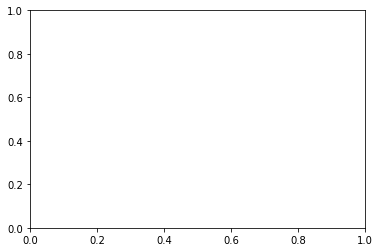

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_df_std, y, test_size=0.3, stratify=y, random_state=SEED)

cov_mat = np.cov(X_train.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,26), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,26), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.title('Principal component and Explained variance ratio')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.axhline(y=0.8, color='r', linestyle='-')
plt.axhline(y=0.9, color='b', linestyle='-')
plt.tight_layout()
plt.show()


To explain 80% variance of the data more than 10 components are required. And to explain 90% it requires 14 components.

In [20]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

In [21]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.3,
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl, s= 10)

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


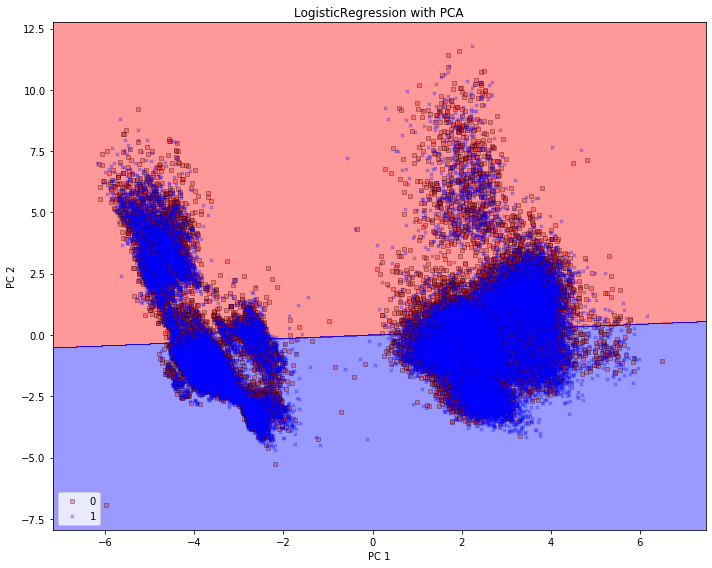

In [22]:
# initializing the PCA transformer and
# logistic regression estimator:
pca = PCA(n_components=2)
lr = LogisticRegression(random_state=42)

# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)

plt.figure(figsize=(10,8))
plot_decision_regions(X_train_pca, y_train, classifier=lr)

plt.title('LogisticRegression with PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [ ]:
PCA are not perfectly linearly separable.

# GridSearchCV

In [ ]:
lr = LogisticRegression(random_state= 42, C = 1)

param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

lr_cv = GridSearchCV(lr, param_grid, cv=10)
lr_cv.fit(X_train, y_train)

print(lr_cv.best_params_) 
print(lr_cv.best_score_)

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

In [ ]:
param_grid = {'n_neighbors': np.arange(1,25)} 

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=10) 

knn_cv.fit(X_train,y_train) 
print(knn_cv.best_params_) 
print(knn_cv.best_score_)

In [ ]:
pipe_svc = make_pipeline(SVC(random_state=42))

param_range = [ 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy',cv=10,refit=True,n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

# ROC & AUC

In [ ]:
clf1 = LogisticRegression(random_state=42, C = 0.001)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=21)
clf4 = RandomForestClassifier(random_state=42)
clf5 = SVC(random_state=42, probability = True, C=0.01, kernel='rbf    

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
pipe5 = Pipeline([['sc', StandardScaler()], ['clf', clf5]])
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3, clf4, pipe5])
    
clf_labels = ['Logistic regression', 'Decision tree', 'KNN', 'RandomForestClassifier', 'SVM', 'mv_clf']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3, clf4, pipe5, mv_clf], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

In [ ]:
colors = ['yellow', 'orange', 'b', 'green', 'r', 'black']
all_clf = [pipe1, clf2, pipe3, clf4, pipe5, mv_clf]
linestyles = [':', '--', '-.', '-', 'solid', '']


plt.figure(figsize=(10,7))

for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc_roc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.title('ROC Curve')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

Logistics regression has aucroc=.81, which means Logistic regression has a excellent performance